In [6]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from typing import *
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import math 
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution
from torch.distributions import Bernoulli
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce

from plotting import make_vae_plots

CMNIST_list = torch.load("data/ColoredMNIST/train1.pt")
CMNIST = pd.DataFrame(CMNIST_list, columns = ["image", "label"])

images = CMNIST.iloc[:,0]
labels_df = CMNIST.iloc[:,1]
labels = torch.tensor(labels_df)

In [7]:
from torchvision.transforms import ToTensor

transform_to_tensor = ToTensor()
transform_to_tensor(images[0]).shape

torch.Size([3, 28, 28])

# Plotting function

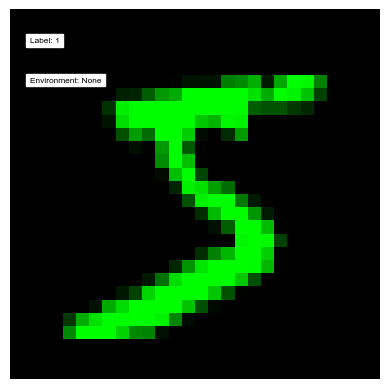

In [8]:
def show_CMNIST(image, label, environment):
    """Show image with landmarks"""
    plt.figure
    plt.imshow(image)
    plt.text(1,2,"Label: {}".format(label), backgroundcolor = "white",
             color = "black", fontsize = 6)
    plt.text(1,5,"Environment: {}".format(environment), backgroundcolor = "white",
             color = "black", fontsize = 6)
    plt.axis('off')
    plt.show
    plt.pause(0.001)  # pause a bit so that plots are updated

show_CMNIST(images[0], labels[0], None)

In [9]:
class CMNISTDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, pt_file, environment=None, transform=None):
        """
        Args:
            pt_file (string): Path to the pt file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            environment (integer): Integer indicating the environment the data comes from
        """
        self.CMNIST_frame = pd.DataFrame(torch.load(pt_file))
        self.transform = transform
        self.environment = environment

    def __len__(self):
        return len(self.CMNIST_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.CMNIST_frame.iloc[idx, 0]
        label = self.CMNIST_frame.iloc[idx, 1]
        sample = {'image': image, 'label': label, "environment": self.environment}

        if self.transform:
            sample = {'image': self.transform(image), 'label': label, "environment": self.environment}

        return sample

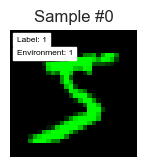

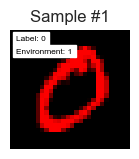

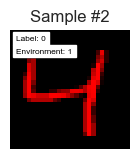

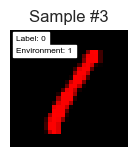

In [10]:
cmnist_data = CMNISTDataset(pt_file = "data/ColoredMNIST/train1.pt", environment = 1)

fig = plt.figure()

for i in range(len(cmnist_data)):
    sample = cmnist_data[i]

    #print(i, sample['image'].shape, sample['label'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_CMNIST(**sample)

    if i == 3:
        plt.show()
        break

In [11]:
cmnist_data1 = CMNISTDataset(pt_file = "data/ColoredMNIST/train1.pt"
                            , environment = 1
                            , transform = transform_to_tensor)
cmnist_data2 = CMNISTDataset(pt_file = "data/ColoredMNIST/train2.pt"
                            , environment = 2
                            , transform = transform_to_tensor)
train_loader = DataLoader(ConcatDataset([cmnist_data1, cmnist_data2]), batch_size=256, num_workers=0)

cmnist_test_data = CMNISTDataset(pt_file = "data/ColoredMNIST/test.pt"
                                 , environment = 3
                                 , transform = transform_to_tensor)
test_loader = DataLoader(cmnist_test_data, batch_size = 512, num_workers = 0)

0 torch.Size([256, 3, 28, 28]) torch.Size([256])
1 torch.Size([256, 3, 28, 28]) torch.Size([256])
2 torch.Size([256, 3, 28, 28]) torch.Size([256])
3 torch.Size([256, 3, 28, 28]) torch.Size([256])


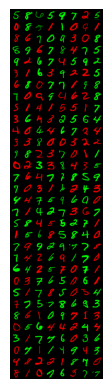

In [12]:
def show_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

# Copied from exercises and adjusted to our dataset:

In [13]:
p = Bernoulli(logits=torch.zeros((1000,)))


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    #def sample_epsilon(self) -> Tensor:
    #    """`\eps ~ N(0, I)`"""
    #    return torch.empty_like(self.mu).normal_()
        
    #def sample(self) -> Tensor:
    #    """sample `z ~ N(z | mu, sigma)` (without gradients)"""
    #    with torch.no_grad():
    #        return self.rsample()
        
    #def rsample(self) -> Tensor:
    #    """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
    #    self.z = torch.distributions.Normal(self.mu, self.sigma)
    #    return self.z.rsample() # <- your code
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        eps = torch.empty_like(self.mu).normal_()
        return self.mu + self.sigma * eps
    # <- your code    
        #return self.mu + self.sigma * self.sample_epsilon() # <- your code    
    
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        return - ((z - self.mu)**2)/(2*self.sigma**2) - torch.log(self.sigma) - math.log(math.sqrt(2 * math.pi)) # <- your code
    
    #def log_prob(self, z:Tensor) -> Tensor:
    #    """return the log probability: log `p(z)`"""
    #    dummy = self.rsample()
    #    return self.z.log_prob(z) # <- your code

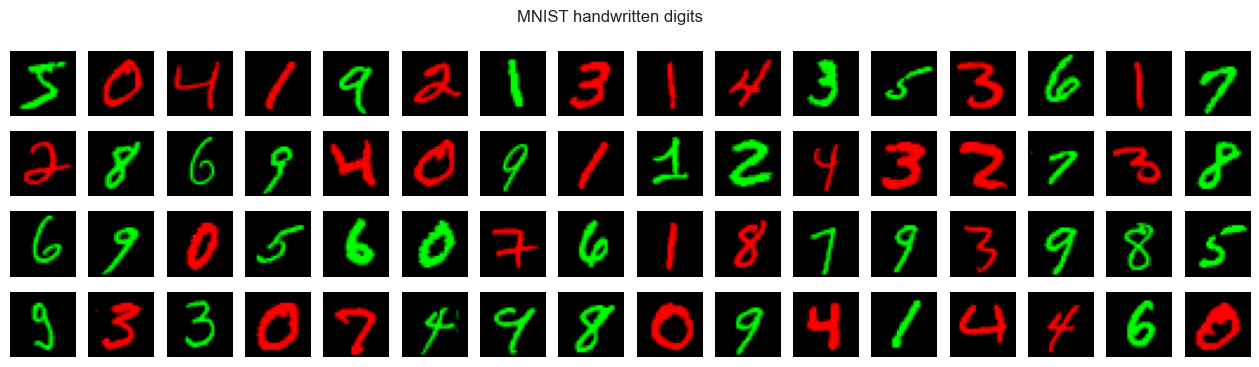

In [14]:
#plot a few CMNIST examples
f, axarr = plt.subplots(4, 16, figsize=(16, 4))

# Load a batch of images into memory
sample = next(iter(train_loader))
images = sample['image']
label = sample['label']
environment = sample['environment']

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].permute(1,2,0))
    ax.axis('off')
    
plt.suptitle('MNIST handwritten digits')
plt.show()

# VAE

In [15]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        ## setting the prior to a vector consisting of zeros with dimensions (1,2*latent_features)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
         #Inference Network
         #Encode the observation `x` into the parameters of the posterior distribution
         #`q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoderCNN1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 2, padding = 1)
        self.encoderCNN2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 2, padding = 1)
        self.encoderCNN3 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 2, padding = 1)
        
        self.encoderFFN2 = nn.Linear(in_features = 32 * 4 * 4, out_features=32 * 4 * 4)
        self.encoderFFN = nn.Linear(in_features = 32 * 4 * 4, out_features=2*latent_features)
        
        #Original network (baseline comparison)
        #self.encoderFFN2 = nn.Linear(in_features = self.observation_features, out_features=256)
        #self.encoderFFN3 = nn.Linear(in_features = 256, out_features=128)
        #self.encoderFFN = nn.Linear(in_features = 128, out_features=2*latent_features)
        
    
         #Generative Model
         #Decode the latent sample `z` into the parameters of the observation model
         #`p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        
        self.relu = nn.ReLU()
        
        #Original network (baseline comparison)
        #self.decoderFFN = nn.Linear(in_features=latent_features, out_features = 128)
        #self.decoderFFN3 = nn.Linear(in_features=128, out_features = 256)
        #self.decoderFFN2 = nn.Linear(in_features = 256, out_features = self.observation_features)
        
        self.decoderFFN = nn.Linear(in_features=latent_features, out_features = 32 * 4 * 4)
        self.decoderFFN2 = nn.Linear(in_features = 32 * 4 * 4, out_features = 32 * 4 * 4)
        
        self.decoderCNN1 = nn.ConvTranspose2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 2, padding = 1
                              ,output_padding = 0)
        self.decoderCNN2 = nn.ConvTranspose2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 2, padding = 1
                              ,output_padding = 1)
        self.decoderCNN3 = nn.ConvTranspose2d(in_channels = 32, out_channels = 3, kernel_size = 3, stride = 2, padding = 1
                              ,output_padding = 1)
        
    #Define encoder and decoder functions which can be modified to include both a CNN and an ordinary FFN    
    def encoder(self, x):
        
        #Add CNN encoder and flatten x
        
        x = relu(self.encoderCNN1(x))
        x = relu(self.encoderCNN2(x))
        x = relu(self.encoderCNN3(x))
        
        x = x.view(x.size(0), -1)
        
        x = self.relu(self.encoderFFN2(x))
        #x = self.relu(self.encoderFFN3(x)) #Only for running "Original"
        x = self.encoderFFN(x)
        return x
   
    def decoder(self, z):
        
        x = self.relu(self.decoderFFN(z))
        #x = self.relu(self.decoderFFN3(x)) #Only for running "Original"
        x = self.relu(self.decoderFFN2(x))
        
        # reshape x and add CNN decoder
        x = x.view(-1, 32, 4, 4)
        
        x = relu(self.decoderCNN1(x))
        x = relu(self.decoderCNN2(x))
        x = self.decoderCNN3(x)
        return x
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        #Expand prior_params til at være samme antal rækker som i den valgte batch size således at der fås
        #en tensor med dimensionerne (batch_size, 2*latent_features), som så kan udfyldes med
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        #chunk opdeler prior_params i to dele, de første 0-latent_features kollonner indeholder mu og 
        #de sidste n_latent_features inde holder sigmaerne. Nu er der to tensors, som begge har dim
        #(batch_size, n_latent_features). Værdierne i disse tensors, kan bruges til at sample hvordan
        #latent space ser ud (Den der hedder 'latent interpolations' i plots i bunden.)
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        #BEMÆRK at at det er log_sigma, dvs. at når den inputtes i ReparameterizedDiagonalGaussian så fås mu = 0, sigma = 1
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        px_logits = self.decoder(z)
        px_logits = px_logits.view(-1, *self.input_shape) # reshape the output #old
        #sandsynlighedsfordeling der giver 1 eller 0, baseret på log-odds givet i logits input fra p(x|z).
        #Dvs. at px_logits angiver sandsynligheden for at det givne pixel er henholdsvist rød,grøn,blå. Pixel værdien
        #er enten 0 eller 1. Når man sampler fra bernoulli fordelingen fås dermed et billede, som givet z, giver en figur,
        #som er bestemt af de sandsynligheder der er i px_logits (p(x|z)). Dvs. at for et givet latents space, kan en
        #figur/et tal reproduceres ud fra de beregnede sandsynligheder og den efterfølgende sample fra Bernoulli fordelingen.
        return Bernoulli(logits=px_logits, validate_args=False)
        

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        ###############################################################################################
        # flatten the input
        #x = x.view(x.size(0), -1) #outcommented as part of adding CNN
        
        #### Run through ENCODER and calculate mu and sigma for latent space sampling
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        #### LATENT SPACE
        z = qz.rsample()
        
        #### DECODER
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        ###############################################################################################
        
        # define the prior p(z)
        #(Indgår i beregning af kl-term (regularisering) ifm. ELBO) - og bruges også til interpolations visualisering
        #til sidst.
        pz = self.prior(batch_size=x.size(0))
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # Laver bare reconstruction baseret på latent space
        #Kan evt. fjernes. Anvendes bare til at vise hvor god modellen er til at generere data baseret på
        #latent space genererede data. Funktionen anvendes kun i make_vae_plots.
        
        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}


latent_features = 10 #Husk at opdater denne parameter nede i 'initialization', hvis den skal bruges i VAE loopet også
vae = VariationalAutoencoder(images[0].shape, latent_features)
print(vae)

VariationalAutoencoder(
  (encoderCNN1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoderCNN2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoderCNN3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoderFFN2): Linear(in_features=512, out_features=512, bias=True)
  (encoderFFN): Linear(in_features=512, out_features=20, bias=True)
  (relu): ReLU()
  (decoderFFN): Linear(in_features=10, out_features=512, bias=True)
  (decoderFFN2): Linear(in_features=512, out_features=512, bias=True)
  (decoderCNN1): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (decoderCNN2): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (decoderCNN3): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)


# ELBO

In [16]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        #The input model in our case is the VAE and the x:tensor is our images.
        
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x)) #log(p(x|z)): Sandsynligheden for at observere vores input variabel x
        #givet vores latent space (tjekker modellens evne til at rekonstruere sig selv, ved at maximere sandsynlig-
        #heden for at observere inputtet selv, givet det konstruerede latent space.
        log_pz = reduce(pz.log_prob(z)) #log(p(z)): Sandsynligheden for at observere vores latent space, givet at
        #latent space følger en standard-normal fordeling (Jo højere sandsynlighed jo bedre)
        log_qz = reduce(qz.log_prob(z)) #log(q(z|x)): Sandsynligheden for at generere netop dette latent space givet 
        #vores input billede x. Denne værdi skal helst være lav?
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) ] - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        #########################################################################################################
        # Reconstruction loss: E_q [ log p(x|z) ]
        # Regularization term: \beta * D_KL(q(z|x) | p(z))` => Forsøger at tvinge fordelingen q(z|x) mod N(0,1)?
        #########################################################################################################
        kl = log_qz - log_pz
        elbo = log_px - kl
        beta_elbo = log_px - self.beta * kl
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs
        

In [17]:
vi = VariationalInference(beta=1)
loss, diagnostics, outputs = vi(vae, images)
print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")

loss   | mean =   1648.859, shape: []
elbo   | mean =  -1648.859, shape: [256]
log_px | mean =  -1648.849, shape: [256]
kl     | mean =      0.009, shape: [256]


# Initialization

In [18]:
from collections import defaultdict
# define the models, evaluator and optimizer

# VAE
latent_features = 10 #Hyper parameter
vae = VariationalAutoencoder(images[0].shape, latent_features)

# Evaluator: Variational Inference
beta = 1 #Hyper parameter
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3) #Hyper parameter, tilføj evt. weight_decay (L2 regularization)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


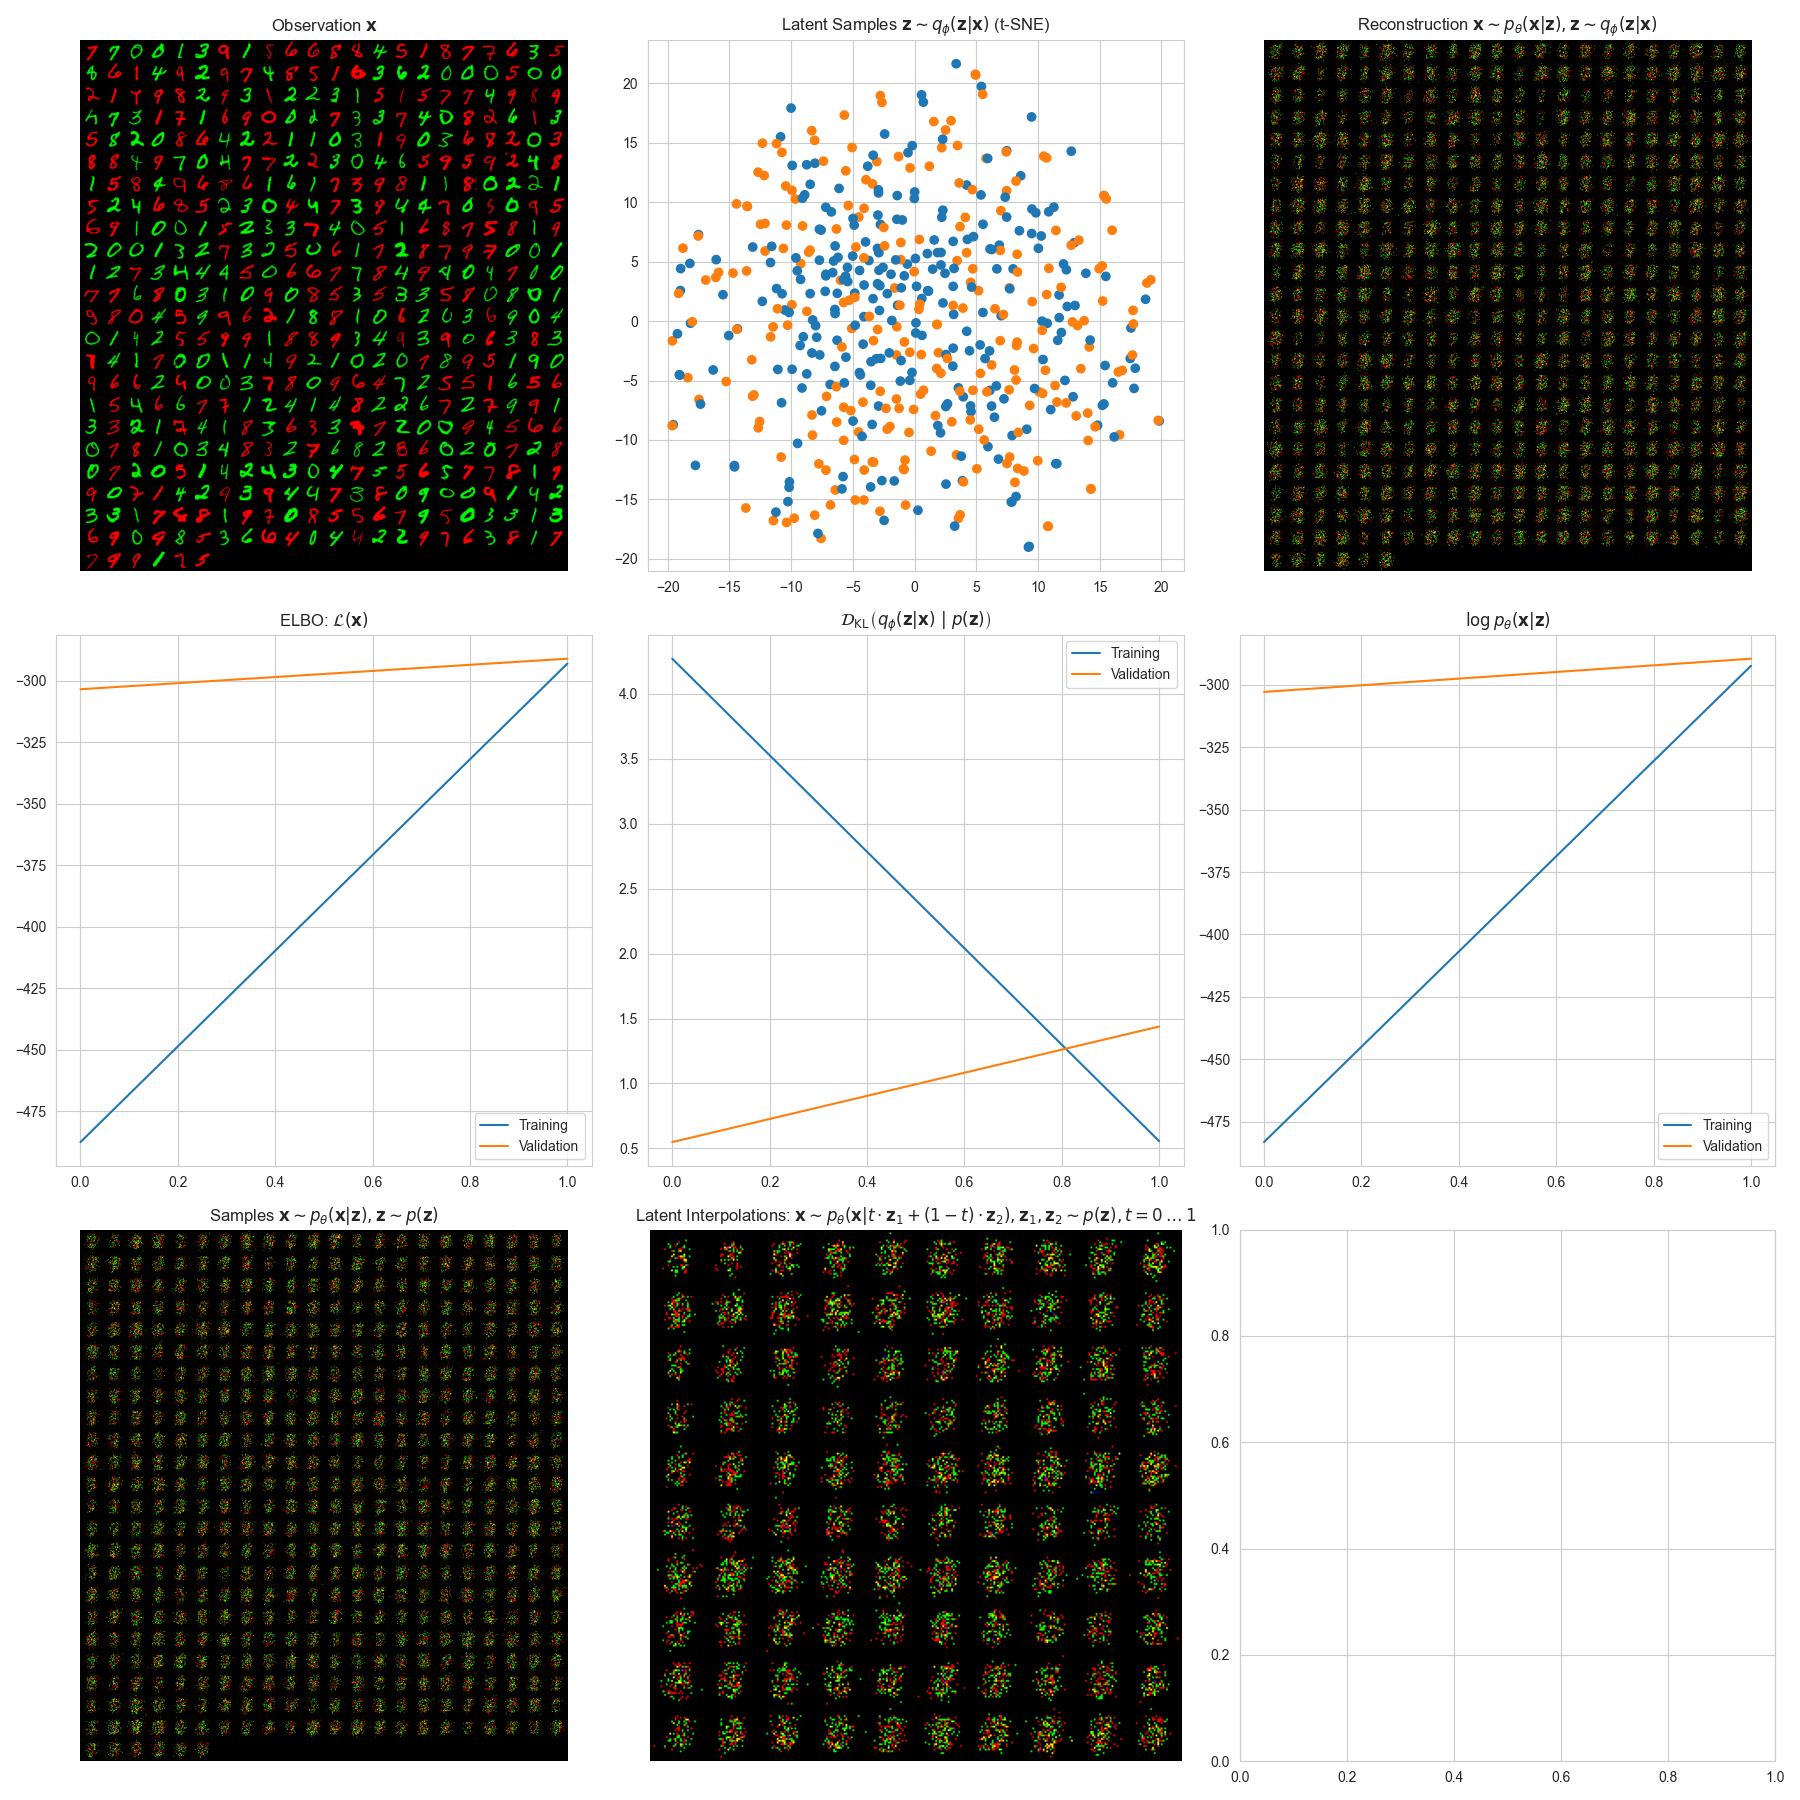

In [19]:
torch.manual_seed(1)
num_epochs = 2 #hyper parametre
#batch size hyper parameter can be changed in the dataloader in the beginning.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
vae = vae.to(device)

# training..
while epoch < num_epochs:
    epoch+= 1
    training_epoch_data = defaultdict(list)
    vae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for sample in train_loader:
        x = sample['image']
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the test loader
        sample = next(iter(test_loader))
        x = sample['image']
        y = sample['label']
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
    
    # Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
    make_vae_plots(vae, x, y, outputs, training_data, validation_data)

In [89]:
qz = vae.posterior(sample['image'])
z = qz.rsample()

In [92]:
#Accuracy function from week 4:
def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

#Building a classifier:

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        #Layers
        self.input_layer = nn.Linear(in_features=10, out_features = 50)
        self.layer1 = nn.Linear(in_features = 50, out_features = 100)
        self.output_layer = nn.Linear(in_features = 100, out_features = 1)

        #activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    #forward function(self, x):
    def forward(self, x):
        
        x = self.input_layer(x)
        x = self.relu(self.layer1(x))
        x = self.sigmoid(self.output_layer(x))

        return x
    # 

classifier = Classifier()
classifier.to(device)



Classifier(
  (input_layer): Linear(in_features=10, out_features=50, bias=True)
  (layer1): Linear(in_features=50, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [130]:
import torch.optim as optim
from sklearn import metrics

#Define loss function
loss_fn = nn.BCELoss() 
#The adam algorithm automatically use momentum
optimizer = optim.Adam(classifier.parameters(), lr = 1e-4) 

#Test model
out = classifier(z[1])
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")

Output shape: torch.Size([1])
Output logits:
[0.51684844]


In [145]:
#TRAINING THE CLASSIFIER
epoch = 0
num_epochs = 10 #hyper parametre
#batch size hyper parameter can be changed in the dataloader in the beginning.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# training..
training_epoch_data = []
test_epoch_data = []

while epoch < num_epochs:
    epoch+= 1
    training_batch_data = []
    test_batch_data = []
    classifier.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for sample in train_loader:
        x = sample['image']
        x = x.to(device)

        y = sample['label'].to(torch.float32)
        y = y.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        qz = vae.posterior(x)
        z = qz.rsample()

        #Get classification prediction
        output = classifier(z).view(-1)

        loss = loss_fn(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current batch
        training_batch_data.append(loss)
            

    # gather data for the full epoch
    training_epoch_data.append(torch.tensor(training_batch_data).mean())

    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        classifier.eval()
        
        # Just load a single batch from the test loader
        sample = next(iter(test_loader))
        x = sample['image']
        y = sample['label'].to(torch.float32)
        x = x.to(device)
        y = y.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        qz = vae.posterior(x)
        z = qz.rsample()
        output = classifier(z)
        
        # gather data for the validation step
        test_batch_data.append(loss)
        test_epoch_data.append(torch.tensor(training_batch_data).mean())
        print("Epoch: {}, Mean epoch loss: {}".format(epoch, torch.tensor(training_batch_data).mean()))
    
    # Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
    

>> Using device: cpu
Epoch: 1, Mean epoch loss: 0.6922487616539001
